In [9]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-sj5aroxh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-sj5aroxh
  Resolved https://github.com/albumentations-team/albumentations to commit b1ebad4c932235918d0aeccf51d070c3080e7516
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [11]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


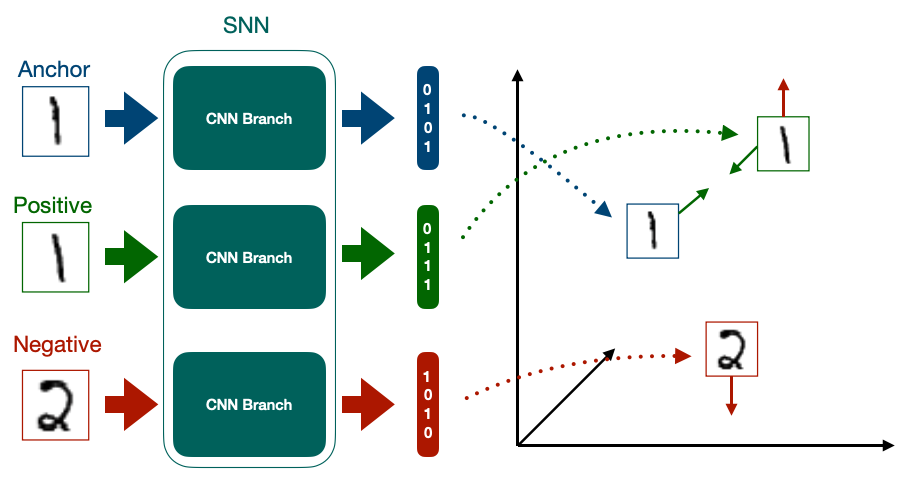

# Imports

In [12]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [14]:
DATA_DIR= '/content/Person-Re-Id-Dataset/train/'
CSV_FILE= '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE=32
LR = 0.001
EPOCHS = 15

DEVICE= 'cuda'

In [15]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [16]:
row = df.iloc[11]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

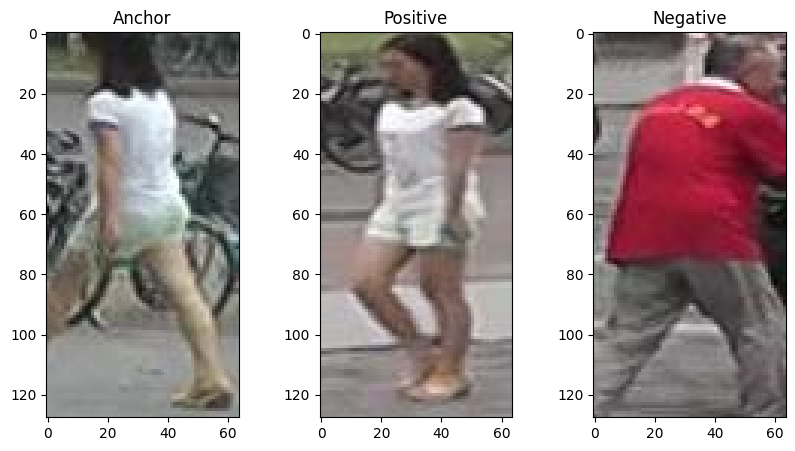

In [17]:
from ast import NamedExpr
f, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [18]:
train_df, valid_df =train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset

In [19]:
class APN_Dataset(Dataset):

    def __init__(self,df):
      self.df=df

    def __len__(self):
      return len(self.df)

    def __getitem__(self,idx):

      row = self.df.iloc[idx]

      A_img = io.imread(DATA_DIR + row.Anchor)
      P_img = io.imread(DATA_DIR + row.Positive)
      N_img = io.imread(DATA_DIR + row.Negative)

      A_img = torch.from_numpy(A_img).permute(2, 0, 1)/255.0
      P_img = torch.from_numpy(P_img).permute(2, 0, 1)/255.0
      N_img = torch.from_numpy(N_img).permute(2, 0, 1)/255.0

      return A_img, P_img, N_img

In [20]:
trainset= APN_Dataset(train_df)
validset= APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


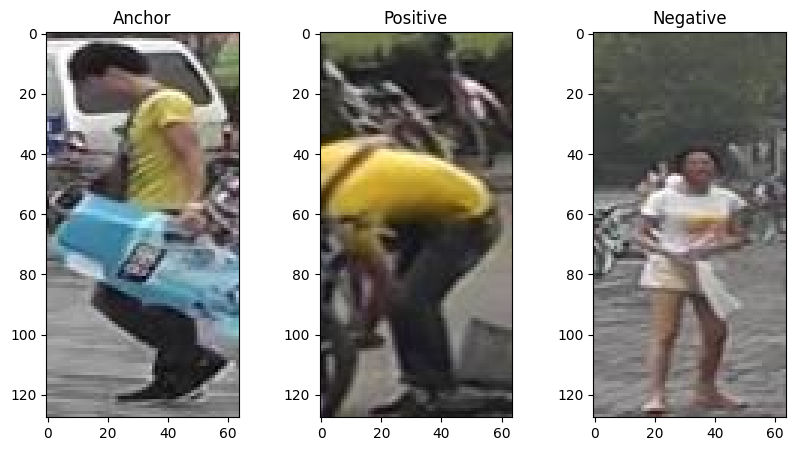

In [21]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [22]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [23]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [24]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [25]:
class APN_Model(nn.Module):

      def __init__(self, emb_size=512):
        super(APN_Model,self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained =True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

      def forward(self, images):
        embeddings = self.efficientnet(images)

        return embeddings

In [26]:
model = APN_Model()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [27]:
def train_fn(model, dataloader, optimizer, criterion):

      model.train()
      total_loss = 0.0

      for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs= model(P)
        N_embs= model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      return total_loss/ len(dataloader)



In [28]:
def eval_fn(model, dataloader,  criterion):

      model.eval()
      total_loss = 0.0
      with torch.no_grad():
        for A, P, N in tqdm(dataloader):

          A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

          A_embs = model(A)
          P_embs= model(P)
          N_embs= model(N)

          loss = criterion(A_embs, P_embs, N_embs)


          total_loss += loss.item()

        return total_loss/ len(dataloader)

In [29]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [30]:
def calculate_rank1_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for anchors, positives, negatives in tqdm(dataloader):
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

            # Get embeddings
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)

            # Calculate distances
            positive_distances = F.pairwise_distance(anchor_embeddings, positive_embeddings)
            negative_distances = F.pairwise_distance(anchor_embeddings, negative_embeddings)

            # Check if positive distance is smaller than negative distance
            correct += torch.sum(positive_distances < negative_distances).item()
            total += anchors.size(0)

    accuracy = correct / total
    return accuracy

In [31]:
best_valid_loss = np.inf
best_accuracy = 0.0
for epoch in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    train_accuracy = calculate_rank1_accuracy(model, trainloader, DEVICE)
    valid_accuracy = calculate_rank1_accuracy(model, validloader, DEVICE)

    print(f"Epoch: {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model_by_accuracy.pt')
        print("SAVED_WEIGHTS_SUCCESS (Best Accuracy)")

    print(f"EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)")


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Epoch: 1
Train Loss: 0.6223, Train Accuracy: 0.8756
Valid Loss: 0.6029, Valid Accuracy: 0.8538
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


Epoch: 2
Train Loss: 0.2949, Train Accuracy: 0.9062
Valid Loss: 0.5083, Valid Accuracy: 0.8812
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Epoch: 3
Train Loss: 0.2762, Train Accuracy: 0.9587
Valid Loss: 0.3624, Valid Accuracy: 0.9213
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Epoch: 4
Train Loss: 0.1413, Train Accuracy: 0.9631
Valid Loss: 0.3170, Valid Accuracy: 0.9363
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Epoch: 5
Train Loss: 0.1016, Train Accuracy: 0.9825
Valid Loss: 0.2203, Valid Accuracy: 0.9425
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  5.71it/s]


Epoch: 6
Train Loss: 0.0878, Train Accuracy: 0.9884
Valid Loss: 0.1671, Valid Accuracy: 0.9550
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Epoch: 7
Train Loss: 0.0416, Train Accuracy: 0.9838
Valid Loss: 0.2295, Valid Accuracy: 0.9350
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Epoch: 8
Train Loss: 0.0424, Train Accuracy: 0.9878
Valid Loss: 0.1900, Valid Accuracy: 0.9487
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Epoch: 9
Train Loss: 0.0486, Train Accuracy: 0.9912
Valid Loss: 0.1616, Valid Accuracy: 0.9600
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]


Epoch: 10
Train Loss: 0.0569, Train Accuracy: 0.9862
Valid Loss: 0.1708, Valid Accuracy: 0.9475
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Epoch: 11
Train Loss: 0.0583, Train Accuracy: 0.9862
Valid Loss: 0.1675, Valid Accuracy: 0.9587
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Epoch: 12
Train Loss: 0.0504, Train Accuracy: 0.9909
Valid Loss: 0.1196, Valid Accuracy: 0.9625
SAVED_WEIGHTS_SUCCESS (Best Accuracy)
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch: 13
Train Loss: 0.0301, Train Accuracy: 0.9909
Valid Loss: 0.1551, Valid Accuracy: 0.9600
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


Epoch: 14
Train Loss: 0.0372, Train Accuracy: 0.9947
Valid Loss: 0.1472, Valid Accuracy: 0.9537
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]

Epoch: 15
Train Loss: 0.0383, Train Accuracy: 0.9894
Valid Loss: 0.1915, Valid Accuracy: 0.9575
EPOCHS : (epoch+1) train_loss: (train_loss) valid_loss: (valid_loss)


# Get Anchor Embeddings

In [32]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
      for i in tqdm(anc_img_names_arr):
        A = io.imread(DATA_DIR + i)
        A = torch.from_numpy(A).permute(2, 0, 1)/255.0
        A = A.to(DEVICE)
        A_enc = model(A.unsqueeze(0))
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

      encodings = np.array(encodings)
      encodings = pd.DataFrame(encodings)
      df_enc = pd.concat([anc_img_names, encodings], axis =1)

    return df_enc

In [34]:
model.load_state_dict(torch.load('/content/best_model_by_accuracy.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-34-64573f0df928>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model_by_accuracy.pt'))
100%|██████████| 400

In [35]:
df_enc.to_csv('database_final.csv', index= False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,1.310201,0.622070,0.024426,0.157230,-0.301919,-1.099459,0.243428,-0.938118,0.467282,...,0.428892,0.470563,0.486987,-0.432134,-0.082580,0.039588,-0.912412,0.566131,0.466870,-0.442597
1,1420_c3s3_061978_03.jpg,1.649830,0.700422,1.039309,-0.115949,-0.553877,-1.283360,-0.162321,-0.503033,0.727830,...,0.414242,0.642219,0.609249,-0.781044,0.233966,-0.117889,-0.640997,0.281742,0.355056,-0.237423
2,1420_c5s3_062565_05.jpg,0.944892,0.629494,-0.027253,0.240974,-0.138372,-0.810125,0.258325,-0.532319,0.369560,...,0.325424,0.361413,0.495254,-0.267605,0.325589,0.028318,-0.588566,0.645982,0.439836,-0.251781
3,1420_c6s3_085592_04.jpg,1.053726,0.217885,0.104203,0.397899,-0.182930,-1.017628,0.410416,-0.890322,0.246440,...,0.397876,0.511867,0.144441,-0.622657,0.202533,-0.044771,-0.832062,0.451548,0.524921,-0.598354
4,0663_c5s3_085987_03.jpg,-0.994757,0.345518,-1.484168,-0.142070,0.738502,1.495008,-0.224746,0.300200,-0.419004,...,-1.025553,-2.241104,-0.143670,0.108264,0.756836,-0.225560,1.963356,0.455893,0.039787,-1.951474


# Inference

In [36]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist= np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [37]:
idx= 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name
img= io.imread(img_path)
img=torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [38]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [39]:
distance =[]

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [40]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


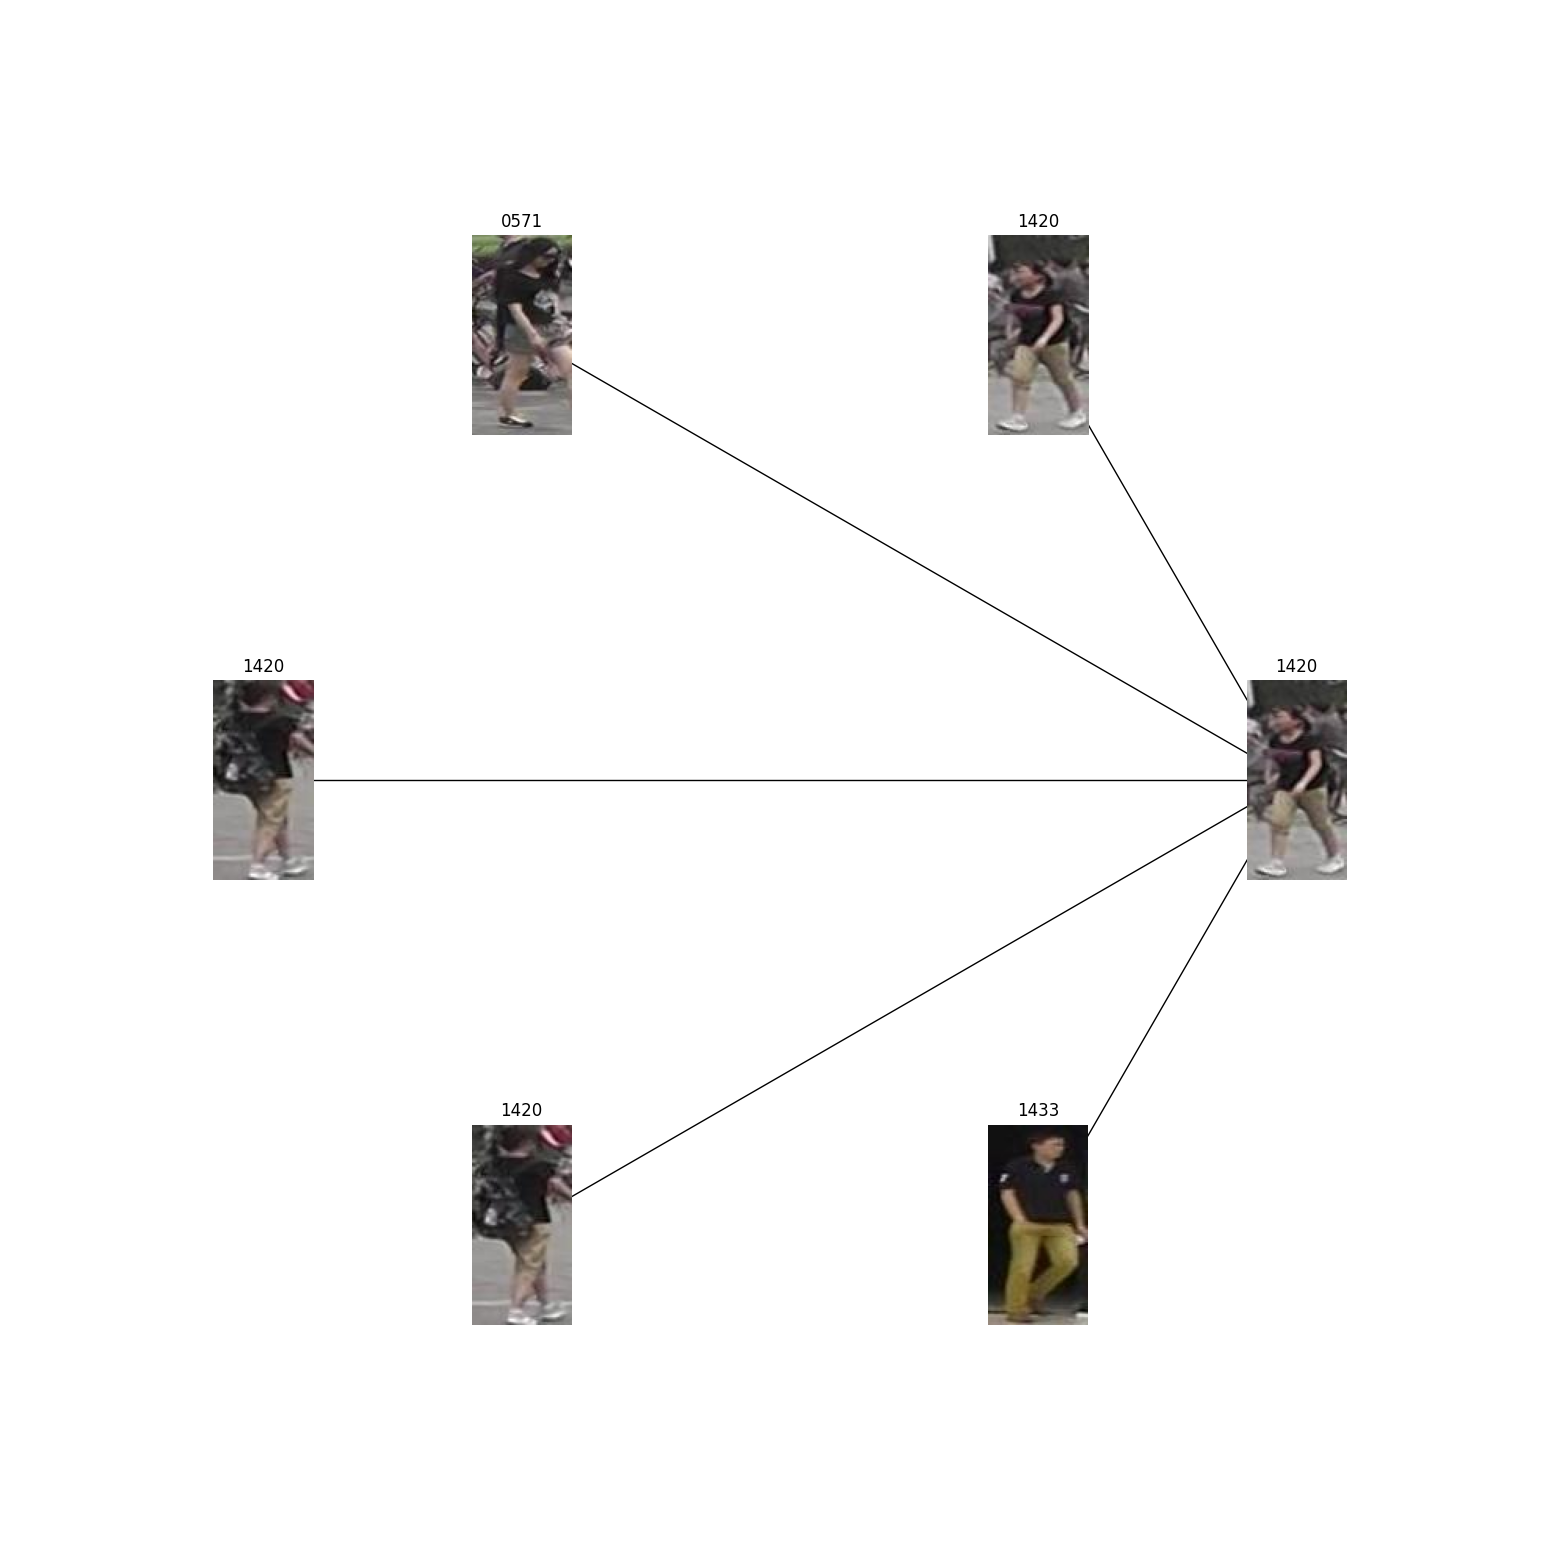

In [41]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);